# Estrutura dos Experimentos com Dados Sintéticos

## 1. Objetivo

Demonstrar funcionamento dos algoritmos de cluster: K-Means, K-Medoids, Ward, DBSCAN e EM (GMM) sob cenários controlados.

In [2]:
#Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import os
import sys
import pandas as pd
from time import time
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_blobs

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)
from dbscan import DBSCAN
from kmeans import KMeans
from kmedoids import KMedoids
from wardmethod import WardMethod
from expectationmaximization import ExpectationMaximization
import distance_metrics
from evaluationmetrics import EvaluationMetrics
from func_auxiliar import plot_algorithm_all_metrics, calculate_clustering_metrics, generate_synthetic_blobs


##### Funções Auxiliares #####

In [3]:
def generate_synthetic_blobs(
    n_samples=1000,
    centers=3,
    cluster_std=0.7,
    random_state=42,
):
    """
    Gera um dataset sintético simples (blobs) só para validar se
    os algoritmos estão funcionando como esperado.
    """
    X, labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
    return X, labels


## Cénario 1: Blobs Simples 

### Objetivo: Desmonstrar funcionamento correto dos algoritmos de Clustering

In [4]:
#Instanciando dataset sintético simples com 3 centros e desvio padrão 0.7
X, labels = generate_synthetic_blobs(n_samples=1000, centers=3, cluster_std=0.7)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [15]:
metrics = ['euclidean_distance', 'manhattan_distance', 'cosine_distance', 'mahalanobis_distance', 'jensen-shannon_distance']

silhouette_metric_name = {
    'euclidean_distance': 'euclidean',
    'manhattan_distance': 'manhattan',
    'cosine_distance': 'cosine',
    'mahalanobis_distance': 'mahalanobis',
    'jensen_shannon_distance': jensenshannon
}

In [16]:
# Pré-cálculo para Mahalanobis
cov_matrix = np.cov(X.T)
cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
VI = np.linalg.inv(cov_matrix)

### Algoritmo: Kmeans

In [19]:
results_kmeans = []
plots_kmeans = {}

for metric_name in metrics:
    kmeans = KMeans(k=3, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    centroids_kmeans, clusters_kmeans = kmeans.fit(X)
    runtime_kmeans = time() - t0
    
    eval_metric = silhouette_metric_name.get(metric_name, 'euclidean')
    eval_kwargs = {} if eval_metric != 'mahalanobis' else {'VI': VI}
    
    metrics_result = calculate_clustering_metrics( algorithm_name="Kmeans", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans,eval_metric=eval_metric, eval_kwargs=eval_kwargs
    )
    results_kmeans.append(metrics_result)
    
    plots_kmeans[metric_name] = {"X": X, "labels": clusters_kmeans, "model": kmeans
    }
    print(f"KMeans com métrica {metric_name} finalizado.")

Convergiu na iteração 3
KMeans com métrica euclidean_distance finalizado.
Convergiu na iteração 3
KMeans com métrica manhattan_distance finalizado.
Convergiu na iteração 25
KMeans com métrica cosine_distance finalizado.
Convergiu na iteração 3
KMeans com métrica mahalanobis_distance finalizado.
Convergiu na iteração 6
KMeans com métrica jensen-shannon_distance finalizado.


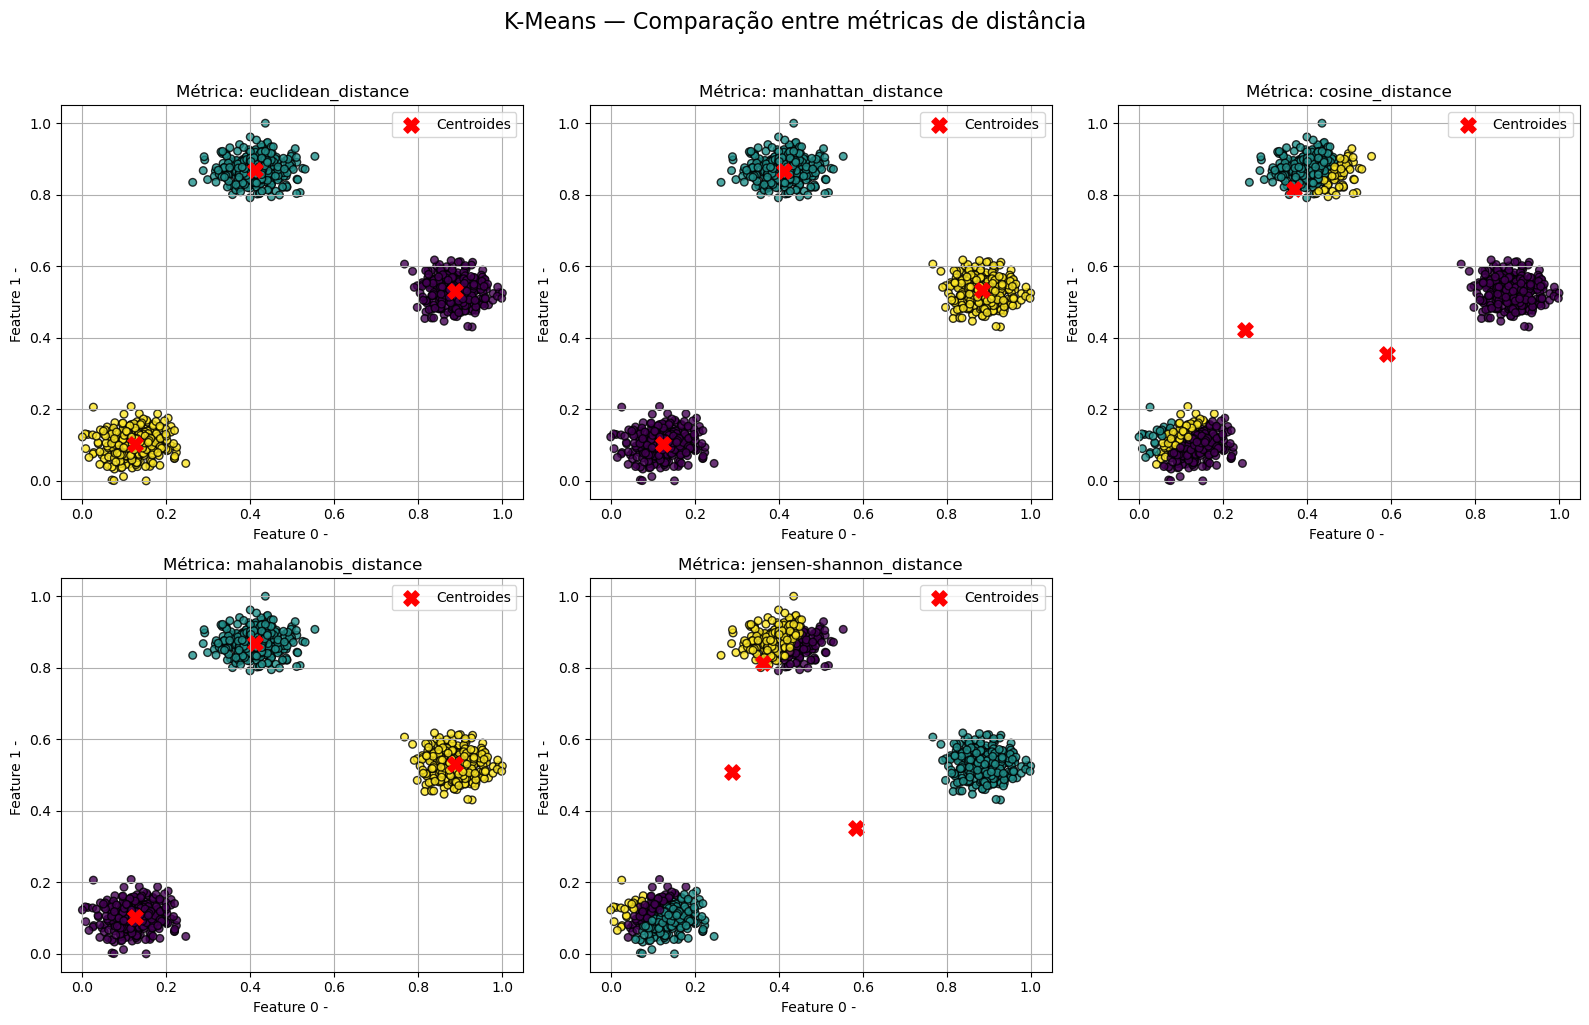

In [20]:
plot_algorithm_all_metrics(plots_kmeans, "K-Means", x_index=0, y_index=1)

In [22]:
#results_kmeans.pop()
df_results_kmeans = pd.DataFrame(results_kmeans)
df_results_kmeans

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Kmeans,euclidean_distance,3,0.033295,3.140698,0.891336,0.152918,31231.749074
1,Kmeans,manhattan_distance,3,0.039764,3.140698,0.898628,0.152918,31231.749074
2,Kmeans,cosine_distance,3,0.446278,139.771037,0.765414,1.992434,214.488372
3,Kmeans,mahalanobis_distance,3,0.039708,3.140698,0.897586,0.152918,31231.749074
4,Kmeans,jensen-shannon_distance,3,0.793583,145.755553,0.219310,2.220002,185.214083


### Algoritmo: Kmedoids

In [23]:
results_kmedoids = []
plots_kmedoids = {}

for metric_name in metrics:
    kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
    runtime_kmedoids = time() - t0
    
    eval_metric = silhouette_metric_name.get(metric_name, 'euclidean')
    eval_kwargs = {} if eval_metric != 'mahalanobis' else {'VI': VI}
    
    metrics_result = calculate_clustering_metrics( algorithm_name="KMedoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids,eval_metric=eval_metric, eval_kwargs=eval_kwargs
    )
    results_kmedoids.append(metrics_result)
    
    plots_kmedoids[metric_name] = {"X": X, "labels": clusters_kmedoids, "model": kmedoids
    }
    print(f"KMedoids com métrica {metric_name} finalizado.")

K-Medoids convergiu na iteração 3
KMedoids com métrica euclidean_distance finalizado.
K-Medoids convergiu na iteração 3
KMedoids com métrica manhattan_distance finalizado.
K-Medoids convergiu na iteração 12
KMedoids com métrica cosine_distance finalizado.
K-Medoids convergiu na iteração 7
KMedoids com métrica mahalanobis_distance finalizado.
K-Medoids convergiu na iteração 17
KMedoids com métrica jensen-shannon_distance finalizado.


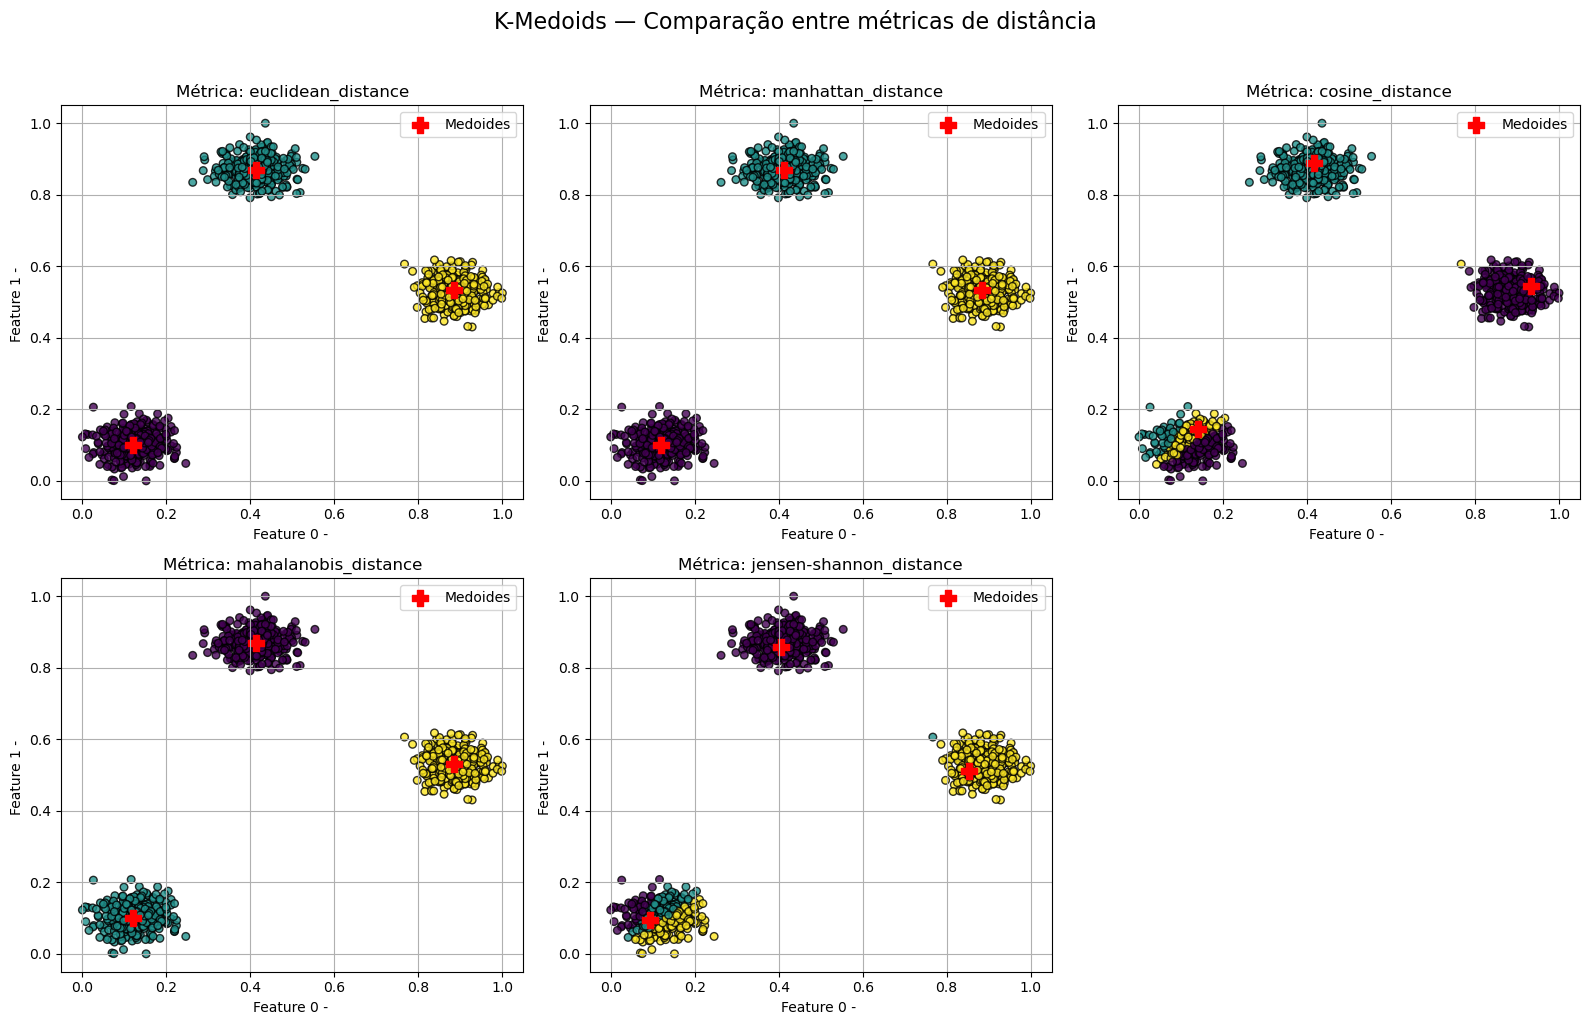

In [49]:
plot_algorithm_all_metrics(plots_kmedoids, "K-Medoids", x_index=0, y_index=1)

In [ ]:
#results_kmedoids.pop(3)
df_results_kmedoids = pd.DataFrame(results_kmedoids)
df_results_kmedoids

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,KMedoids,euclidean_distance,3,2.948967,3.140698,0.891336,0.152918,31231.749074
1,KMedoids,manhattan_distance,3,3.894650,3.140698,0.898628,0.152918,31231.749074
2,KMedoids,cosine_distance,3,28.958147,108.716190,0.849038,0.992511,418.153944
3,KMedoids,jensen-shannon_distance,3,301.457029,108.021991,0.360329,0.987813,424.044781
4,KMedoids,mahalanobis_distance,3,8.020603,3.140698,0.897586,0.152918,31231.749074


### Algoritmo: DBSCAN

In [115]:
results_dbscan = []
plots_dbscan = {}

for metric_name in metrics:
    dbscan = DBSCAN(eps=0.3, min_samples=10, metric=metric_name)
    t0 = time()
    dbscan.fit(X)
    runtime_dbscan = time() - t0
    labels_dbscan = dbscan.labels_
    
    eval_metric = silhouette_metric_name.get(metric_name, 'euclidean')
    eval_kwargs = {} if eval_metric != 'mahalanobis' else {'VI': VI}
    
    metrics_result = calculate_clustering_metrics( algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X, labels=labels_dbscan,eval_metric=eval_metric, eval_kwargs=eval_kwargs
    )
    results_dbscan.append(metrics_result)
    
    plots_dbscan[metric_name] = {"X": X, "labels": labels_dbscan, "model": dbscan
    }
    print(f"DBSCAN com métrica {metric_name} finalizado.")

DBSCAN com métrica euclidean_distance finalizado.
DBSCAN com métrica manhattan_distance finalizado.
DBSCAN com métrica cosine_distance finalizado.
DBSCAN com métrica mahalanobis_distance finalizado.
DBSCAN com métrica jensen_shannon_distance finalizado.


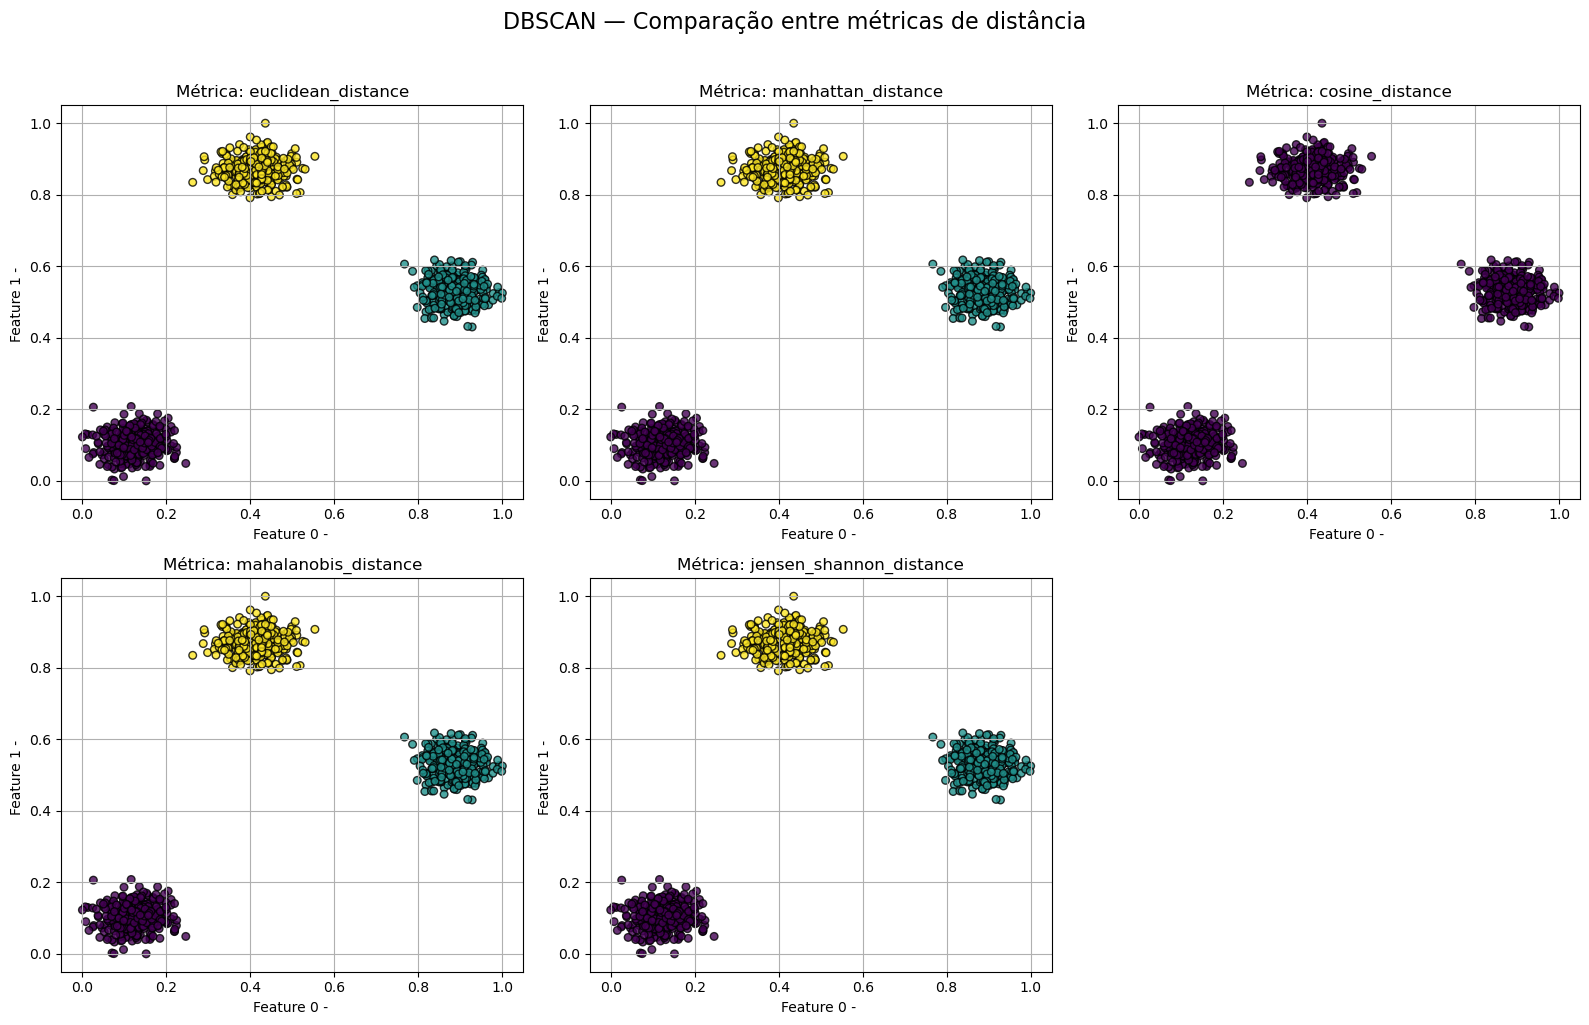

In [116]:
plot_algorithm_all_metrics(plots_dbscan, "DBSCAN", x_index=0, y_index=1)

In [117]:
#results_kmedoids.pop()
df_results_dbscan = pd.DataFrame(results_dbscan)
df_results_dbscan

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,DBSCAN,euclidean_distance,3,5.582215,3.140698,0.891336,0.152918,31231.749074
1,DBSCAN,manhattan_distance,3,6.983786,3.140698,0.898628,0.152918,31231.749074
2,DBSCAN,cosine_distance,1,13.575135,199.909978,NaN,NaN,NaN
3,DBSCAN,mahalanobis_distance,3,7.695676,3.140698,0.897586,0.152918,31231.749074
4,DBSCAN,jensen_shannon_distance,3,5.760241,3.140698,0.417540,0.152918,31231.749074


### Algoritmo: EM

In [25]:
results_em = []
plots_em = {}

for metric_name in metrics:
    em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    em.fit(X)
    runtime_em = time() - t0
    labels_em = em.labels_
    
    eval_metric = silhouette_metric_name.get(metric_name, 'euclidean')
    eval_kwargs = {} if eval_metric != 'mahalanobis' else {'VI': VI}
    
    metrics_result = calculate_clustering_metrics( algorithm_name="EM", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em,eval_metric=eval_metric, eval_kwargs=eval_kwargs
    )
    results_em.append(metrics_result)
    
    plots_em[metric_name] = {"X": X, "labels": labels_em, "model": em
    }
    print(f"EM com métrica {metric_name} finalizado.")

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


EM com métrica euclidean_distance finalizado.
EM com métrica manhattan_distance finalizado.
EM com métrica cosine_distance finalizado.
EM com métrica mahalanobis_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


EM com métrica jensen-shannon_distance finalizado.


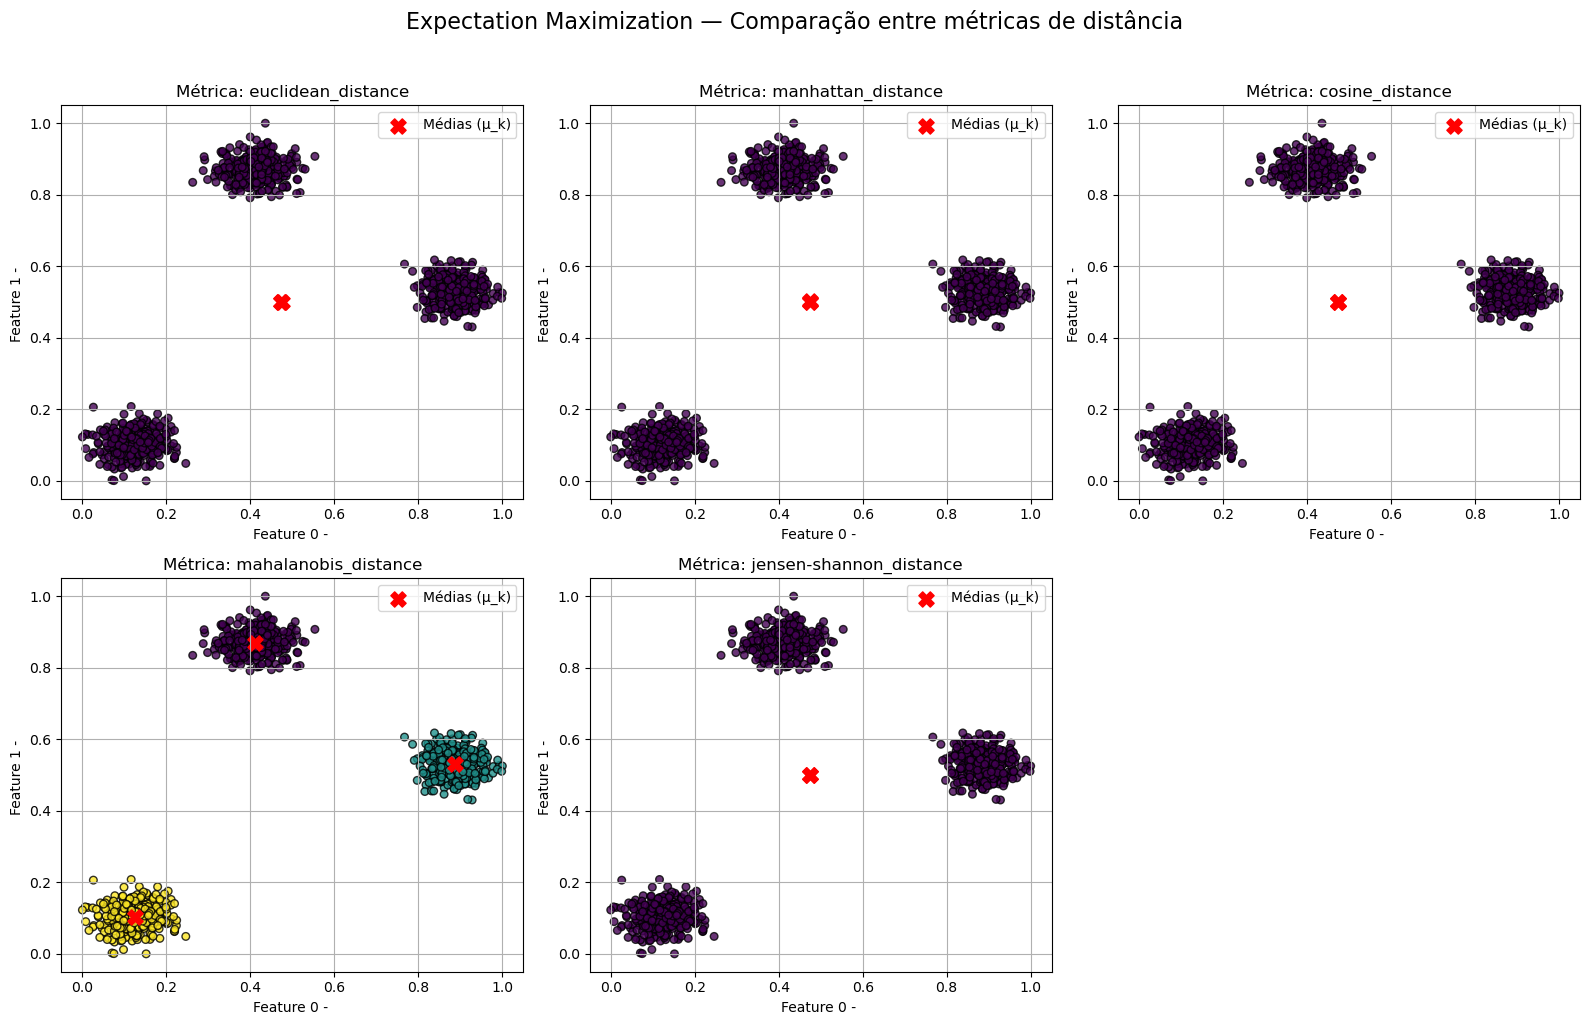

In [26]:
plot_algorithm_all_metrics(plots_em, "Expectation Maximization", x_index=0, y_index=1)

In [27]:
#results_kmedoids.pop()
df_results_em = pd.DataFrame(results_em)
df_results_em

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,EM,euclidean_distance,1,0.126579,199.909978,NaN,NaN,NaN
1,EM,manhattan_distance,1,0.269094,199.909978,NaN,NaN,NaN
2,EM,cosine_distance,1,0.116369,199.909978,NaN,NaN,NaN
3,EM,mahalanobis_distance,3,0.013346,3.140698,0.897586,0.152918,31231.749074
4,EM,jensen-shannon_distance,1,0.840706,199.909978,NaN,NaN,NaN


### Algoritmo: Ward

In [ ]:
results_ward = []
plots_ward = {}

for metric_name in metrics:
    ward = WardMethod(k=3, metric=metric_name)
    t0 = time()
    labels_ward = ward.fit_predict(X)
    runtime_ward = time() - t0
    
    eval_metric = silhouette_metric_name.get(metric_name, 'euclidean')
    eval_kwargs = {} if eval_metric != 'mahalanobis' else {'VI': VI}
    
    metrics_result = calculate_clustering_metrics( algorithm_name="Ward", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward,eval_metric=eval_metric, eval_kwargs=eval_kwargs
    )
    results_ward.append(metrics_result)
    
    plots_ward[metric_name] = {"X": X, "labels": labels_ward, "model": ward
    }
    print(f"Ward com métrica {metric_name} finalizado.")

Ward com métrica euclidean_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:42: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


Ward com métrica manhattan_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:42: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


Ward com métrica cosine_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:42: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


Ward com métrica mahalanobis_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/wardmethod.py:42: UserWarning: WardMethod: o método de Ward clássico é definido para distância Euclidiana. Outras métricas são experimentais e não preservam a interpretação exata de variância mínima.
  warnings.warn(


Ward com métrica jensen-shannon_distance finalizado.


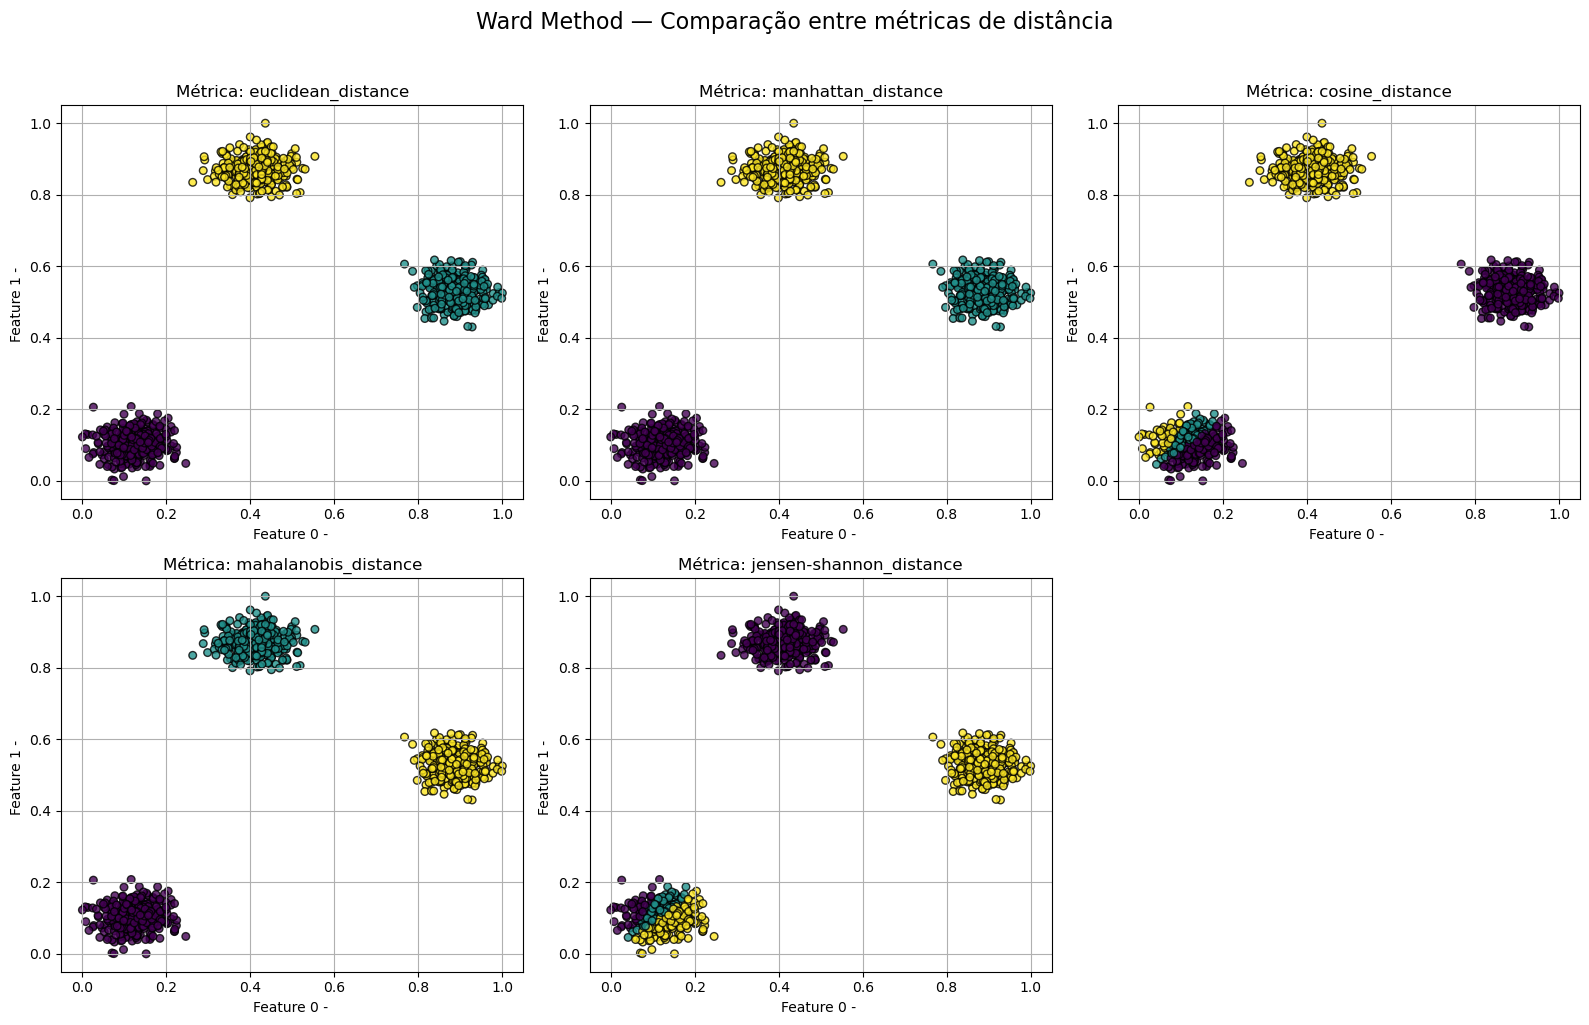

In [39]:
plot_algorithm_all_metrics(plots_ward, "Ward Method", x_index=0, y_index=1)

In [47]:
#results_kmedoids.pop()
df_results_ward= pd.DataFrame(results_ward)
df_results_ward

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Ward,euclidean_distance,3,627.662554,3.140698,0.891336,0.152918,31231.749074
1,Ward,manhattan_distance,3,744.207376,3.140698,0.898628,0.152918,31231.749074
2,Ward,cosine_distance,3,1040.654519,116.564102,0.838614,1.033877,356.438381
3,Ward,mahalanobis_distance,3,862.807479,3.140698,0.897586,0.152918,31231.749074
4,Ward,jensen-shannon_distance,3,7322.932757,116.564102,0.294699,1.033877,356.438381
